# MODEL GRIDS WITH PYCLOUDY

## The upper envelope of HII regions in the BPT diagram

### Build a grid of plane-parallel photoionization models with open geometry, density nH= 100 cm$^{-3}$, no dust, varying log U between -4.5 and -1.5 by steps of 0.5 dex, for the metallicities Z = 0.001, 0.002, 0.008, 0.02, 0.040 taking as ionization source a Black Body at 50kK.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pyCloudy as pc
pc.config.cloudy_exe = '/usr/local/Cloudy/c25.00_rc2/source/cloudy.exe'
models_dir = '../models/'

warng pyCloudy config: pyCloudy works better with matplotlib Triangulation


##### We define a function to manage the models.

In [8]:
options = ('no molecules',
           'no level2 lines',
           'no fine opacities',
           'atom h-like levels small',
           'atom he-like levels small',
           'element limit off -7',
            )

from pyCloudy.utils.physics import abund_Asplund_2009

def make_mod(name, logU, Z_str, grains=False, NoO_law=False):
    assert Z_str in ('0.001', '0.004', '0.008', '0.020', '0.040')
    Z = float(Z_str)
    NH = 100
    ff = 1.0
    abund = abund_Asplund_2009.copy()    
    delta_O = np.log10(Z/0.020)
    for elem in abund:
        if elem != 'He':
            abund[elem] += delta_O
    if NoO_law:
        X = 12 + abund['O']
        if X < 8:
            abund['N'] = abund['O'] - 1.6
        else:        
            abund['N'] = abund['O'] + 1.6 * (X - 8) - 1.6
    c_input = pc.CloudyInput('{0}/{1}'.format(models_dir, name))
    c_input.set_BB(Teff=50000, 
                   lumi_unit = 'ionization parameter', lumi_value = logU)
    c_input.set_cste_density(np.log10(NH), ff = ff)
    c_input.set_abund(ab_dict = abund)
    c_input.set_iterate(1)
    if grains:
        c_input.set_grains('Orion {}'.format(10**delta_O))
    c_input.set_distance(dist=1., unit='kpc', linear=True)
    c_input.set_other(options)
    c_input.set_stop(('temperature off', 'pfrac 0.02'))
    c_input.set_emis_tab(['H  1  4861.32A', 'H  1  6562.80A', 
                          'N  2  6583.45A', 'O  3  5006.84A'])
    c_input.print_input()

In [9]:
generic_name = 'M72_'

In [10]:
for logU in np.arange(-4.5, -1.49, 0.5):
    for Z in ('0.001', '0.004', '0.008', '0.020', '0.040'):
        # making 35 models
        name = '{}{:.1f}_{}'.format(generic_name, logU, Z)
        make_mod(name, logU, Z, grains=True)

In [11]:
pc.run_cloudy(dir_=models_dir, n_proc=7, model_name=generic_name)

##### We read the results into a list.

In [12]:
Ms = pc.load_models('{}/{}'.format(models_dir, generic_name))

warng CloudyModel ../models/M72_-2.0_0.001: r_out_cut must be greater than minimal value
warng CloudyModel ../models/M72_-1.5_0.040: r_out_cut must be greater than minimal value
warng CloudyModel ../models/M72_-2.0_0.004: r_out_cut must be greater than minimal value
warng CloudyModel ../models/M72_-4.5_0.040: r_out_cut must be greater than minimal value
warng CloudyModel ../models/M72_-2.5_0.020: r_out_cut must be greater than minimal value
warng CloudyModel ../models/M72_-2.5_0.008: r_out_cut must be greater than minimal value
warng CloudyModel ../models/M72_-3.0_0.040: r_out_cut must be greater than minimal value
warng CloudyModel ../models/M72_-3.5_0.001: r_out_cut must be greater than minimal value
warng CloudyModel ../models/M72_-4.0_0.001: r_out_cut must be greater than minimal value
warng CloudyModel ../models/M72_-2.5_0.040: r_out_cut must be greater than minimal value
warng CloudyModel ../models/M72_-3.0_0.008: r_out_cut must be greater than minimal value
warng CloudyModel ../

In [13]:
print([M.n_zones for M in Ms])
for M in Ms:
    print('{:.2f} {:.2f}'.format(M.abund['O'], M.log_U_mean))

[173, 219, 174, 142, 177, 159, 172, 198, 217, 121, 111, 189, 143, 164, 111, 119, 142, 119, 205, 195, 105, 131, 151, 133, 124, 146, 135, 193, 106, 149, 150, 196, 180, 159, 152]
-4.61 -2.00
-3.01 -1.50
-4.01 -2.00
-3.01 -4.50
-3.31 -2.50
-3.71 -2.50
-3.01 -3.00
-3.71 -1.50
-3.31 -1.50
-4.61 -3.50
-4.61 -4.00
-3.01 -2.50
-3.71 -3.00
-3.31 -3.00
-4.01 -4.00
-3.71 -4.50
-3.31 -4.50
-4.01 -3.50
-3.01 -2.00
-4.61 -1.50
-4.01 -4.50
-3.71 -3.50
-3.31 -3.50
-4.01 -3.00
-3.71 -4.00
-3.31 -4.00
-4.61 -3.00
-4.01 -1.50
-4.61 -4.50
-4.01 -2.50
-3.01 -4.00
-3.31 -2.00
-3.71 -2.00
-3.01 -3.50
-4.61 -2.50


##### We read the observations into the obs variable.

In [16]:
obs = np.genfromtxt('./BPT4Graz_f4.dat.gz', names=True)

##### We check that the observations correspond to what we expect.

Text(0, 0.5, 'log [OIII]/Hb')

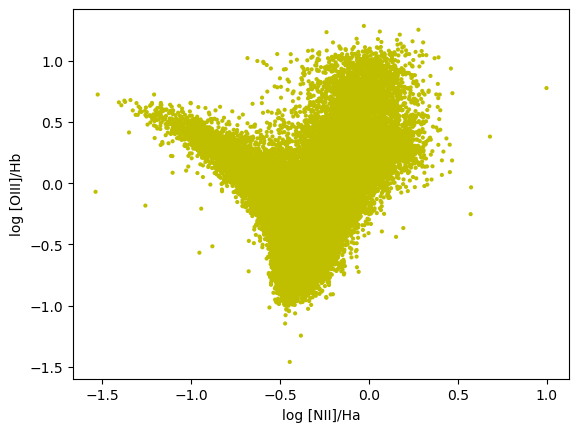

In [17]:
f, ax = plt.subplots()
ax.scatter(obs['xN2Ha'], obs['yO3Hb'], edgecolor='none', color='y', 
           marker='.')
ax.set_xlabel('log [NII]/Ha')
ax.set_ylabel('log [OIII]/Hb')

In [18]:
Ms[0].emis_labels

array(['H__1_486132A', 'H__1_656280A', 'N__2_658345A', 'O__3_500684A'],
      dtype='<U12')

### Overplot the grid of photoionization models, joining models with same metallicities by dashed lines and models with same ionization parameter by continuous lines and comment on the resulting plot.

(-2.5, 1.5)

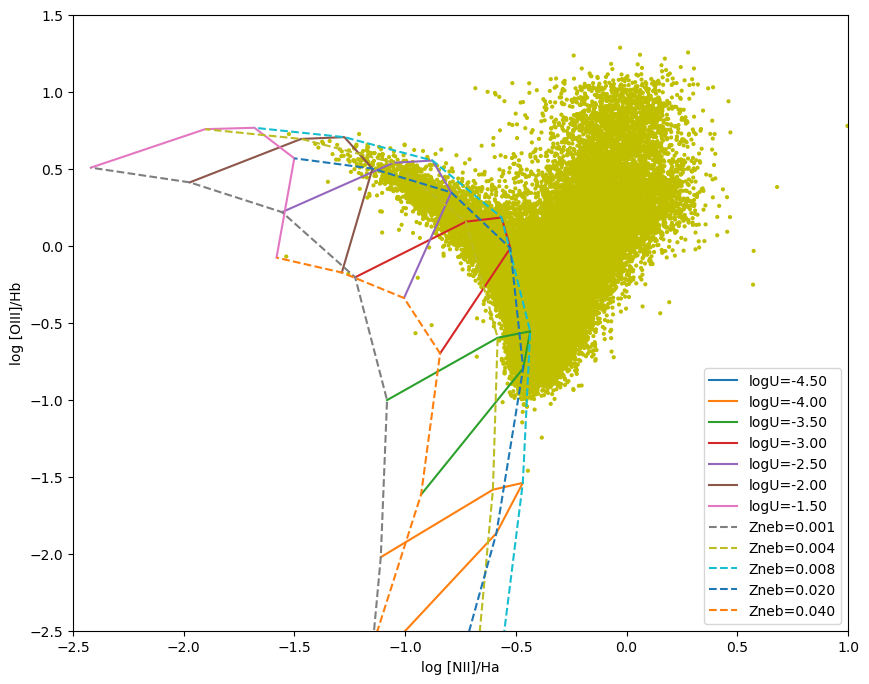

In [20]:
f, ax = plt.subplots(figsize=(10,8))
ax.scatter(obs['xN2Ha'], obs['yO3Hb'], edgecolor='none', color='y', 
           marker='.')
ax.set_xlabel('log [NII]/Ha')
ax.set_ylabel('log [OIII]/Hb')

# A small function to extract a line intensity from all the models 
extract_line = lambda label:np.array([M.get_emis_vol(label) for M in Ms])
    
Ha = extract_line('H__1_656280A')
Hb = extract_line('H__1_486132A')
O3 = extract_line('O__3_500684A')
N2 = extract_line('N__2_658345A')

# Recover the list of unique values of the input parameters from the name of the model:
Z = np.array([float(M.model_name_s.split('_')[2]) for M in Ms])
Z_u = np.sort(np.unique(Z))
logU = np.array([float(M.model_name_s.split('_')[1]) for M in Ms])
logU_u = np.sort(np.unique(logU))
    
for logU1 in logU_u:
    s = np.where(logU == logU1)[0] # find the indices where logU is the current logU1
    indx = s[Z[s].argsort()] #find and sort the indices of the models with the 
    ax.plot(np.log10(N2/Ha)[indx], np.log10(O3/Hb)[indx], linestyle='-', label = 'logU={0:.2f}'.format(logU1))
for Z1 in Z_u:
    s = np.where(Z == Z1)[0] # 
    indx = s[logU[s].argsort()]
    ax.plot(np.log10(N2/Ha)[indx], np.log10(O3/Hb)[indx], linestyle='--', label = 'Zneb={0:.3f}'.format(Z1))
ax.legend(loc=4)
    
ax.set_xlim((-2.5, 1))
ax.set_ylim((-2.5, 1.5))
